Библиотеки

In [1]:
import os
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm.auto import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    DataCollatorWithPadding
)

In [2]:
# from google.colab import drive
# drive.mount('/mnt/drive')

Загрузка данных

In [3]:
data_path = '/content/drive/MyDrive/IMDB Dataset.csv'
raw_df = pd.read_csv(data_path)
raw_df['label'] = raw_df['sentiment'].map({'negative':0, 'positive':1})

Разбиение на train / validation / test
По размерам кусков договорились внутри

In [4]:
from sklearn.model_selection import train_test_split
train_val, test_df = train_test_split(raw_df, test_size=0.3, random_state=42)
train_df, valid_df = train_test_split(train_val, test_size=0.2, random_state=42)
print(f"Tr: {len(train_df)}, Val: {len(valid_df)}, Te: {len(test_df)}")

Tr: 28000, Val: 7000, Te: 15000


Токенайзер

In [5]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Подготовка Dataset и DataLoader

In [6]:
class ReviewDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.texts = df['review'].tolist()
        self.labels = df['label'].tolist()
        self.tok   = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tok(
            self.texts[idx],
            truncation=True,
            max_length=self.max_len,
            return_attention_mask=True
        )
        enc['labels'] = self.labels[idx]
        return enc

In [7]:
train_ds = ReviewDataset(train_df, tokenizer)
val_ds   = ReviewDataset(valid_df, tokenizer)
test_ds  = ReviewDataset(test_df, tokenizer)

In [8]:
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=data_collator)
val_loader   = DataLoader(val_ds,   batch_size=16, collate_fn=data_collator)
test_loader  = DataLoader(test_ds,  batch_size=16, collate_fn=data_collator)

Пайплайн для дообучения

In [9]:
class SentimentPipeline:
    def __init__(self, model_name, device='cuda'):
        self.device = device if torch.cuda.is_available() else 'cpu'
        self.model = BertForSequenceClassification.from_pretrained(
            model_name, num_labels=2
        ).to(self.device)

    def configure_optim(self, lr=2e-5, wd=0.01):
        self.optimizer = AdamW(self.model.parameters(), lr=lr, weight_decay=wd)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=5)

    def run_epoch(self, loader, train=True):
        self.model.train() if train else self.model.eval()
        total_loss, correct, total = 0., 0, 0

        loop = tqdm(loader, desc="Train" if train else "Eval ")
        for batch in loop:
            batch = {k:v.to(self.device) for k,v in batch.items()}
            out = self.model(**batch)
            loss = out.loss

            if train:
                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()

            total_loss += loss.item()
            preds = out.logits.argmax(dim=-1)
            correct += (preds == batch['labels']).sum().item()
            total += batch['labels'].size(0)

        if train:
            self.scheduler.step()
        return total_loss/len(loader), correct/total

    def fit(self, train_loader, val_loader, epochs=3, save_path="final_model.bin"):
        history = {'tr_loss':[], 'tr_acc':[], 'val_loss':[], 'val_acc':[]}

        for ep in range(1, epochs+1):
            print(f"\n=== Epoch {ep}/{epochs} ===")
            tr_l, tr_a = self.run_epoch(train_loader, train=True)
            val_l, val_a = self.run_epoch(val_loader,   train=False)

            history['tr_loss'].append(tr_l)
            history['tr_acc'].append(tr_a)
            history['val_loss'].append(val_l)
            history['val_acc'].append(val_a)

            print(f"Train Loss={tr_l:.4f} acc={tr_a:.4f}")
            print(f"Val loss={val_l:.4f} acc={val_a:.4f}")

        torch.save(self.model.state_dict(), save_path)
        print(f"\n Обучение завершилось. Сохраняю модель `{save_path}`")
        return history

    def evaluate(self, loader):
        loss, acc = self.run_epoch(loader, train=False)
        print(f"Test loss={loss:.4f}, acc={acc:.4f}")

Настройка оптимизатора и шедулера

In [10]:
pipeline = SentimentPipeline("bert-base-uncased")
pipeline.configure_optim(lr=3e-5, wd=0.02)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Обучение / оценка

In [11]:
hist = pipeline.fit(train_loader, val_loader, epochs=2)
pipeline.evaluate(test_loader)


=== Epoch 1/2 ===


Train:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval :   0%|          | 0/438 [00:00<?, ?it/s]

Train Loss=0.2819 acc=0.8895
Val loss=0.2326 acc=0.9167

=== Epoch 2/2 ===


Train:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval :   0%|          | 0/438 [00:00<?, ?it/s]

Train Loss=0.1647 acc=0.9491
Val loss=0.2698 acc=0.9207

 Обучение завершилось. Сохраняю модель `final_model.bin`


Eval :   0%|          | 0/938 [00:00<?, ?it/s]

Test loss=0.2736, acc=0.9188


Визуализация лосса и аккураси

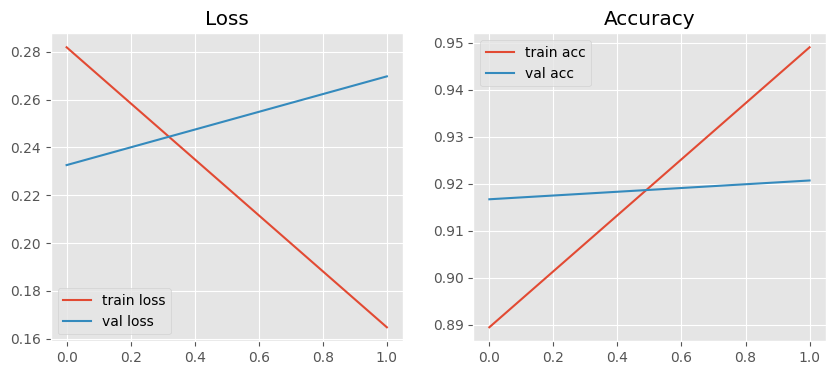

In [12]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist['tr_loss'],  label='train loss')
plt.plot(hist['val_loss'],  label='val loss')
plt.legend(); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(hist['tr_acc'],   label='train acc')
plt.plot(hist['val_acc'],   label='val acc')
plt.legend(); plt.title("Accuracy")
plt.show()